# RSI


- 가격 움직임의 가옫/크기를 포착하고자 기간 동안의 가격 변화를 기반으로 함
- 0~100범위 정규화 해 RSI계산, 손실에 비해 더 많은 이익이 있었는지, 이익 대비 더 많은 손실이 있었는지 포착
- 50% 넘는 RSI값은 상승추세, 50%아래 RSI값은 하락 추세

In [1]:
import pandas as pd
from pandas_datareader import data
import statistics as stats
import matplotlib.pyplot as plt

In [2]:
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

try:
  goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data2.to_pickle(SRC_DATA_FILENAME)

goog_data = goog_data2.tail(620)

close = goog_data['Close']

In [3]:
time_period = 20     # 손익을 계산하기 위한 룩백 기간
gain_history = []    # 룩백 기간 동안의 이익 히스토리 (0 if no gain, magitude of gain if gain)
loss_history = []    # 룩백 기간 동안의 손실 히스토리 (0 if no loss, magnitude of loss if loss)
avg_gain_values = [] # 시각화를 위해 평균 이익을 추적
avg_loss_values = [] # 시각화를 위해 평균 손실을 추적
rsi_values = []      # 계산된 RSI 값을 추적
last_price = 0       # 현재가격 - 최근가격 > 0 => 이익. 현재가격 - 최근가격 < 0 => 손실.

for close_price in close:
  if last_price == 0:
    last_price = close_price

  gain_history.append(max(0, close_price - last_price))
  loss_history.append(max(0, last_price - close_price))
  last_price = close_price

  if len(gain_history) > time_period: # 관찰 수는 룩백 기간과 동일
    del (gain_history[0])
    del (loss_history[0])

  avg_gain = stats.mean(gain_history) # 룩백 기간의 평균 이익
  avg_loss = stats.mean(loss_history) # 룩백 기간의 평균 손실

  avg_gain_values.append(avg_gain)
  avg_loss_values.append(avg_loss)

  rs = 0
  if avg_loss > 0:                    # 나눠서 정의되지 않는 것을 방지
    rs = avg_gain / avg_loss

  rsi = 100 - (100 / (1 + rs))
  rsi_values.append(rsi)

- 20일 기간을 사용해 평균 이익과 평균 손실을 계산하고, RSI 공식에 따라 0과 100사이 값으로 정규화

In [4]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgGainOver20Days=pd.Series(avg_gain_values, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgLossOver20Days=pd.Series(avg_loss_values, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthIndicatorOver20Days=pd.Series(rsi_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
rs_gain = goog_data['RelativeStrengthAvgGainOver20Days']
rs_loss = goog_data['RelativeStrengthAvgLossOver20Days']
rsi = goog_data['RelativeStrengthIndicatorOver20Days']


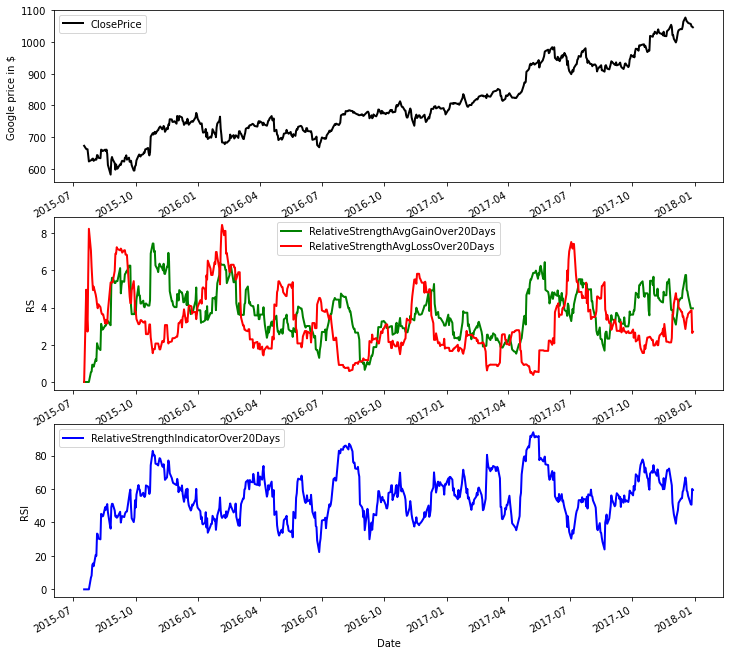

In [7]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='black', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='RS')
rs_gain.plot(ax=ax2, color='g', lw=2., legend=True)
rs_loss.plot(ax=ax2, color='r', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='RSI')
rsi.plot(ax=ax3, color='b', lw=2., legend=True)
plt.show()